In [1]:
# Importing Required Python Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',None)

In [2]:
# Reading in the dataset & getting its info
df = pd.read_csv('prepared_data.csv',index_col='Date',parse_dates=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 72 entries, 2016-10-01 to 2019-09-01
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Vol       72 non-null     float64
 1   Category  72 non-null     object 
dtypes: float64(1), object(1)
memory usage: 1.7+ KB


In [3]:
# Segregating the dataset for buiscuits and Chocolate
bis = df.loc[df['Category'] == 'BISCUIT']
choc = df.loc[df['Category'] != 'BISCUIT']

In [5]:
# Converting the biscuit volume series into pandas series
bis_s = (bis['Vol']).copy()

In [6]:
# Taking log of the biscuit volume series to reduce variance
bis_log = np.log10(bis_s)

### As has been observed previously, the bis_log series is non_stationary with seasonality equal to 12, we would be employing holt winters tests, with and without both trend & stationarity.

### Fitting Holt Winter's Exponential smoothing models on the log_bis series. 

In [7]:
from math import sqrt
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
from numpy import array

In [8]:
# one-step Holt Winters Exponential Smoothing forecast
def exp_smoothing_forecast(history, config):
    ''' Performs one step forecasting for univaritae series using Exponential Smoothing Function'''
    t,d,s,p,b,r = config
    # define model
    history = array(history)
    model = ExponentialSmoothing(history, trend=t, damped=d, seasonal=s, seasonal_periods=p)
    # fit model
    model_fit = model.fit(optimized=True, use_boxcox=b, remove_bias=r)
    # make one step forecast
    yhat = model_fit.predict(len(history), len(history))
    return yhat[0]

In [9]:
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

In [10]:
def walk_forward_validation(data, n_test, config):
    ''' Outputs the test set RMSE
    data: The time series sequence
    n_test: no. of test observations
    cfg : configuration tuple '''
    #print('entering walk_forward')
    predictions = []
    # split dataset
    train, test = train_test_split(data, n_test)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # fit model and make forecast for history
        yhat = exp_smoothing_forecast(history, config)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
        #print('prediction {} done'.format(i))
    # estimate prediction error
    error = sqrt(mean_squared_error(test, predictions))
    #print('Leaving walk_forward_validation')
    return error

In [11]:
def score_func(data, n_test, config):
    ''' Calculates the rmse of the Exponential smoothing model by making a call to walk_forward_validation function 
     within a try except bloc'''
    #print('entering score_func')
    try:
        error = walk_forward_validation(data, n_test, config)
    except:
        print('entering except block')
        error = None 
    #print('leaving score_func')
    return (str(config), error)     

In [12]:
def grid_search(data, n_test, config, parallel=True):
    ''' performs a grid search of Exponential smoothing hyper-parameters using multicores'''
    #scores = None
    # Entering 
    '''if parallel:
        print('Entering Parallel')
        executor = Parallel(n_jobs=(cpu_count()-1), backend='multiprocessing')
        print('past executor')
        tasks = (delayed(score_func)(data, n_test, cfg, enforce) for cfg in config)
        print('past tasks')
        scores = executor(tasks)
        print('scores assigned')
        
    else: '''
    scores = [score_func(data, n_test, cfg) for cfg in config]
    scores = [s for s in scores if s[1] != None]
    # sort the scores in ascending order
    scores.sort(key=lambda x: x[1])
    #print('leaving grid_search')
    return scores

In [14]:
def gen_configs(seasonal=[0]):
    '''generates configurations for exponential smoothing model'''
    config = []
    t_params = ['add', 'mul', None] # Trend parameter : Additive/Multiplicative
    d_params = [True, False]        # Tend damped or not
    s_params = ['add', 'mul', None] # Seasonal component: additive Or Multiplicative
    p_params = seasonal             # Seasonality of the series
    b_params = [True, False]        # Use Box_cox transformations
    r_params = [True, False]        # Remove bias from forecast values and fitted values 
                                    # by enforcing that the average residual is equal to zero
    # create config instances
    for t in t_params:
        for d in d_params:
            for s in s_params:
                for p in p_params:
                    for b in b_params:
                        for r in r_params:
                            cfg = [t,d,s,p,b,r]
                            config.append(cfg)
    return config

In [19]:
# Initializing the required data for the analysis of the log_biscuit series
data = bis_log 
n_test = 6
config = gen_configs([0,3,12])

In [20]:
print('Total no. of different configurations to be tested are: ',len(config))

Total no. of different configurations to be tested are:  216


### Evaluating Holt Winter's Exponential smoothing models

In [21]:
# Evaluating the scores for various configurations when stationarity has been enforced
scores =  grid_search(data, n_test, config)

entering except block
entering except block
entering except block
entering except block
entering except block
entering except block
entering except block
entering except block
entering except block
entering except block
entering except block
entering except block
entering except block
entering except block
entering except block
entering except block
entering except block
entering except block
entering except block
entering except block
entering except block
entering except block
entering except block
entering except block
entering except block
entering except block
entering except block
entering except block


C:\Users\panka\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\panka\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\panka\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\panka\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


entering except block
entering except block
entering except block
entering except block
entering except block
entering except block
entering except block
entering except block
entering except block
entering except block
entering except block
entering except block
entering except block
entering except block
entering except block
entering except block
entering except block
entering except block
entering except block
entering except block
entering except block
entering except block
entering except block
entering except block
entering except block
entering except block
entering except block
entering except block
entering except block
entering except block
entering except block
entering except block
entering except block
entering except block
entering except block
entering except block
entering except block
entering except block
entering except block
entering except block
entering except block
entering except block
entering except block
entering except block
entering except block
entering e

In [22]:
# Printing the final scores
scores

[("['add', False, 'mul', 12, False, False]", 0.02472926983353512),
 ("['add', False, 'mul', 12, False, True]", 0.02497112370292588),
 ("['mul', False, 'mul', 12, False, True]", 0.025393401284710293),
 ("['mul', False, 'mul', 12, False, False]", 0.02540706792529933),
 ("['add', True, 'mul', 12, False, True]", 0.02543732870436983),
 ("['add', True, 'add', 12, False, True]", 0.02544067455860782),
 ("['add', True, 'add', 12, False, False]", 0.025446516375088477),
 ("['add', True, 'mul', 12, False, False]", 0.025470381964872894),
 ("['add', False, 'add', 12, False, False]", 0.02547714285180749),
 ("['add', False, 'add', 12, False, True]", 0.025479286897133503),
 ("['add', False, 'mul', 12, True, False]", 0.025493153558478466),
 ("['add', False, 'mul', 12, True, True]", 0.025598364002459798),
 ("['mul', False, 'add', 12, False, True]", 0.025699300112409944),
 ("['mul', False, 'add', 12, False, False]", 0.025718139125124457),
 ("['mul', False, 'add', 12, True, False]", 0.02578727234626988),
 

In [23]:
print('The no. of unstable original configurations that were feeded to the Exponential Smoothing model are: ',len(config)-len(scores))

The no. of unstable original configurations that were feeded to the Exponential Smoothing model are:  76


### Checking if the best Exponential Smoothing model with config ['add', False, 'mul', 12, False, False] has stable configuration.

In [24]:
# Performing train test split of the biscuit series
y_train, y_test = train_test_split(data, n_test)

In [25]:
# Training the model again
model_exp = ExponentialSmoothing(y_train, trend='add', damped=False, seasonal='mul', seasonal_periods=12)
model_exp_fit = model_exp.fit(optimized=True, use_boxcox=False, remove_bias=False)
print(model_exp_fit.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                      Vol   No. Observations:                   30
Model:             ExponentialSmoothing   SSE                              0.050
Optimized:                         True   AIC                           -159.937
Trend:                         Additive   BIC                           -137.518
Seasonal:                Multiplicative   AICC                           -97.755
Seasonal Periods:                    12   Date:                 Tue, 02 Mar 2021
Box-Cox:                          False   Time:                         15:17:56
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level              1.4901e-08                alpha                 True
smoothing_trend          

C:\Users\panka\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


### Observations: 
### 1) The above model seems to have fitted the data well, as no box-cox transformation was used which was anticipated, as the time series was log_series  and further plot pointed to additive trend and multiplicative seasonal component of periodicity 12. The model picked up all of them.
### 2) But one drawback of the above model is the residuals are not forced to have mean 0, which may lead to a biased model. Thus lets try refitting the next best model, which has all the same parameters but for remove_bias=True. 

In [26]:
# Training the next best model again
model_exp = ExponentialSmoothing(y_train, trend='add', damped=False, seasonal='mul', seasonal_periods=12)
model_exp_fit = model_exp.fit(optimized=True, use_boxcox=False, remove_bias=True)
print(model_exp_fit.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                      Vol   No. Observations:                   30
Model:             ExponentialSmoothing   SSE                              0.050
Optimized:                         True   AIC                           -159.937
Trend:                         Additive   BIC                           -137.518
Seasonal:                Multiplicative   AICC                           -97.755
Seasonal Periods:                    12   Date:                 Tue, 02 Mar 2021
Box-Cox:                          False   Time:                         15:40:57
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level              1.4901e-08                alpha                 True
smoothing_trend          

C:\Users\panka\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


### Observations: 
### 1) The above model has also beautifully fitted the dataset, with same AICC as that of the previous model, but with the added advantage of the residual average being equal to zero & test set rmse being almost equal to that of the previous model.

### Conclusions:
### 1) Thus our Exponential Smoothing model of choice for this dataset is the 2nd best model with configuration               "[ trend = 'add', damped = False,seasonal = 'mul', periodicity = 12, boxcox transform = False, rem_bias = True]"
### 2) The test set rmse corresponding to this model = 0.02497112 , which is less than the best naive_ model rmse score of 0.051231104. Thus our chosen exponential smoothing model does have some predictive power.


In [28]:
# Getting the predictions for the next 6 months.
bis_log_preds = model_exp_fit.predict(start=len(bis_log),end=(len(bis_log)+5))

In [29]:
bis_log_preds

2019-10-01    5.883533
2019-11-01    5.835723
2019-12-01    5.849232
2020-01-01    5.964780
2020-02-01    5.905034
2020-03-01    5.922811
Freq: MS, dtype: float64

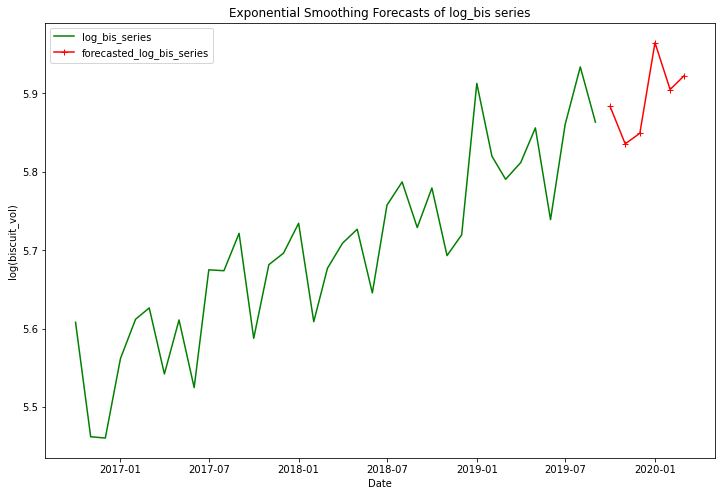

In [30]:
# Displaying the True & Predicted values of the biscuit series
plt.figure(figsize=(12,8))
plt.plot(bis_log,color='green',label='log_bis_series')
plt.plot(bis_log_preds,color='red',marker='+',label='forecasted_log_bis_series')
plt.legend(loc='upper left')
plt.xlabel('Date')
plt.ylabel('log(biscuit_vol)')
plt.title('Exponential Smoothing Forecasts of log_bis series')
plt.show()